In [1]:
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", branches)
        # Each branch is added to the dictionary
        for branch in branches:
            all_branches[branch] = tree[branch].array(library="np")
    return all_branches

# Branches relevant to the occupancy selections
mod_occ_branches = ['module_layers', 'module_subdets', 'module_rings', 'module_eta',
                    'md_occupancies', 'sg_occupancies', 't3_occupancies', 't5_occupancies']

# Root file generated with compile -d option turned on to generate relevant occupancy branches
file_path = "occ_1000_p06.root"
branches = load_root_file(file_path, mod_occ_branches)

In [2]:
events = np.shape(branches['module_layers'])[0]

module_layers = np.concatenate(branches['module_layers'])
module_subdets = np.concatenate(branches['module_subdets'])
module_rings = np.concatenate(branches['module_rings'])
module_eta = np.abs(np.concatenate(branches['module_eta']))

category_numbers = np.full_like(module_layers, -1)

# Different category masks
mask1 = (module_layers <= 3) & (module_subdets == 5)
mask2 = (module_layers >= 4) & (module_subdets == 5)
mask3 = (module_layers <= 2) & (module_subdets == 4) & (module_rings >= 11)
mask4 = (module_layers >= 3) & (module_subdets == 4) & (module_rings >= 8)
mask5 = (module_layers <= 2) & (module_subdets == 4) & (module_rings <= 10)
mask6 = (module_layers >= 3) & (module_subdets == 4) & (module_rings <= 7)

category_numbers[mask1] = 0
category_numbers[mask2] = 1
category_numbers[mask3 | mask4] = 2
category_numbers[mask5 | mask6] = 3

eta_numbers = np.full_like(module_eta, -1)

# Different eta masks
eta_numbers[module_eta < 0.75] = 0
eta_numbers[(module_eta >= 0.75) & (module_eta < 1.5)] = 1
eta_numbers[(module_eta >= 1.5) & (module_eta < 2.25)] = 2
eta_numbers[(module_eta >= 2.25) & (module_eta < 3)] = 3

# Split the arrays back into event-wise lists
split_indices = np.cumsum([len(x) for x in branches['module_layers'][:-1]])

category_numbers_split = np.split(category_numbers, split_indices)
eta_numbers_split = np.split(eta_numbers, split_indices)

# Add category number and eta number branches
branches['category_number'] = np.array(category_numbers_split, dtype=object)
branches['eta_number'] = np.array(eta_numbers_split, dtype=object)

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size' : 20}

matplotlib.rc('font', **font)

def plot_histogram(data, title, xlabel, ylabel, occ_percentile=None):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.yscale('log')
    # Plotting a vertical line at the occupancy value
    if occ_percentile is not None:
        non_zero_data = data[data > 0]
        percentile_value = np.percentile(non_zero_data, occ_percentile)
        plt.axvline(percentile_value, color='red', linestyle='dashed', linewidth=1, label=f'{occ_percentile}th percentile: {percentile_value:.0f}')
        plt.legend()
    plt.show()

In [4]:
def compute_occupancies(branches, occupancy_variables, occ_percentiles, plot=False):
    cat_eta_combinations = [(cat, eta) for cat in range(4) for eta in range(4)]

    for var, percentile in zip(occupancy_variables, occ_percentiles):
        for cat, eta in cat_eta_combinations:
            data_to_plot = [
                occupancy for sublist_cat, sublist_eta, sublist_occ in zip(branches['category_number'], branches['eta_number'], branches[var])
                for c, e, occupancy in zip(sublist_cat, sublist_eta, sublist_occ) if c == cat and e == eta
            ]
            data_to_plot = np.array(data_to_plot)
            non_zero_data = data_to_plot[data_to_plot > 0]
            if non_zero_data.any():
                if plot:
                    plot_histogram(data_to_plot, f'{var} for Category {cat} and Eta {eta}', 'Occupancy', 'Frequency', percentile)
                else:
                    percentile_value = np.percentile(non_zero_data, percentile)
                    print(f'{var} for Category {cat} and Eta {eta} - {percentile}th percentile: {percentile_value:.0f}')

md_occupancies for Category 0 and Eta 0 - 99.99th percentile: 60
md_occupancies for Category 0 and Eta 1 - 99.99th percentile: 57
md_occupancies for Category 0 and Eta 2 - 99.99th percentile: 54
md_occupancies for Category 0 and Eta 3 - 99.99th percentile: 48
md_occupancies for Category 1 and Eta 0 - 99.99th percentile: 259
md_occupancies for Category 1 and Eta 1 - 99.99th percentile: 195
md_occupancies for Category 2 and Eta 1 - 99.99th percentile: 23
md_occupancies for Category 2 and Eta 2 - 99.99th percentile: 28
md_occupancies for Category 3 and Eta 1 - 99.99th percentile: 25
md_occupancies for Category 3 and Eta 2 - 99.99th percentile: 25
md_occupancies for Category 3 and Eta 3 - 99.99th percentile: 33
sg_occupancies for Category 0 and Eta 0 - 99.9th percentile: 936
sg_occupancies for Category 0 and Eta 1 - 99.9th percentile: 351
sg_occupancies for Category 0 and Eta 2 - 99.9th percentile: 256
sg_occupancies for Category 0 and Eta 3 - 99.9th percentile: 61
sg_occupancies for Categ

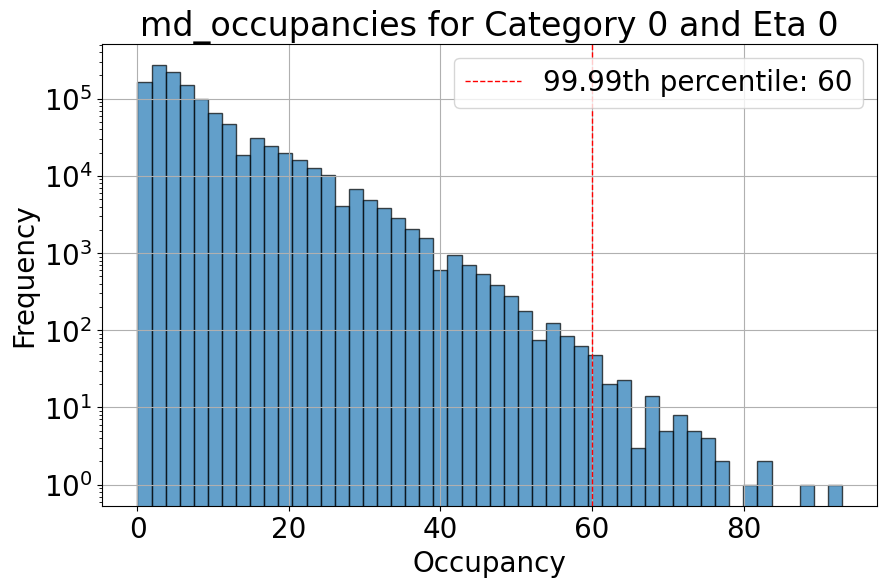

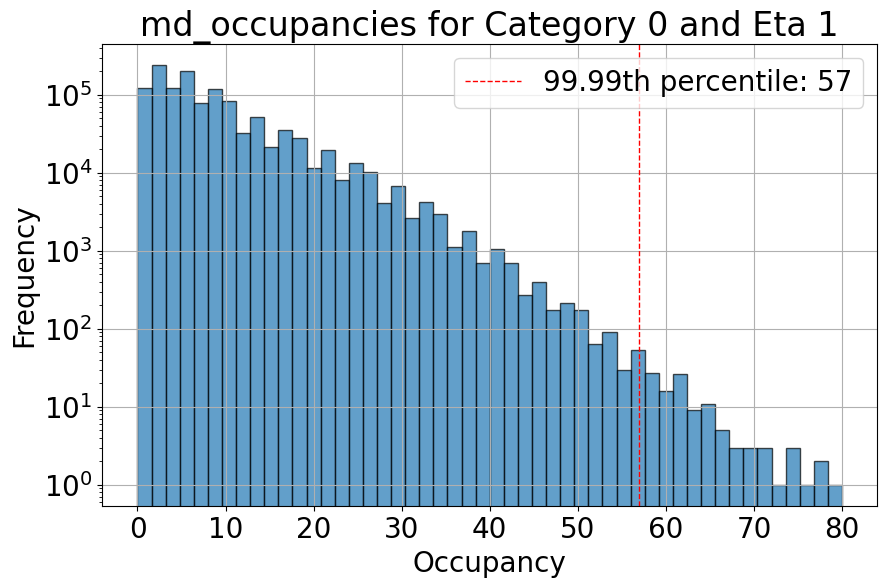

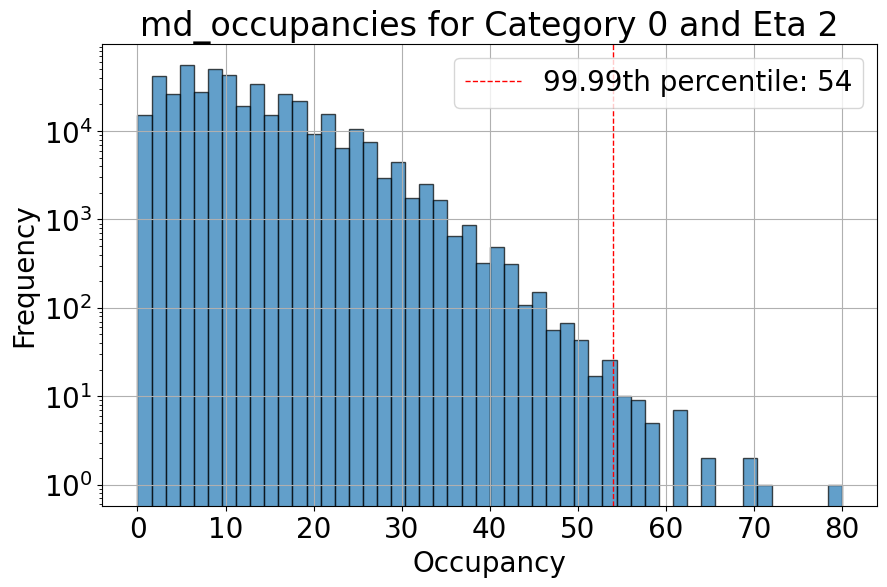

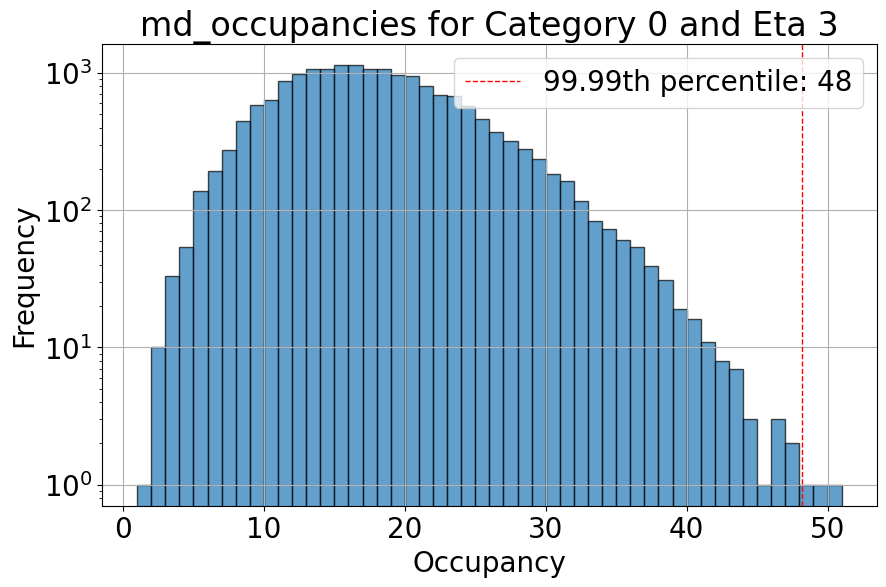

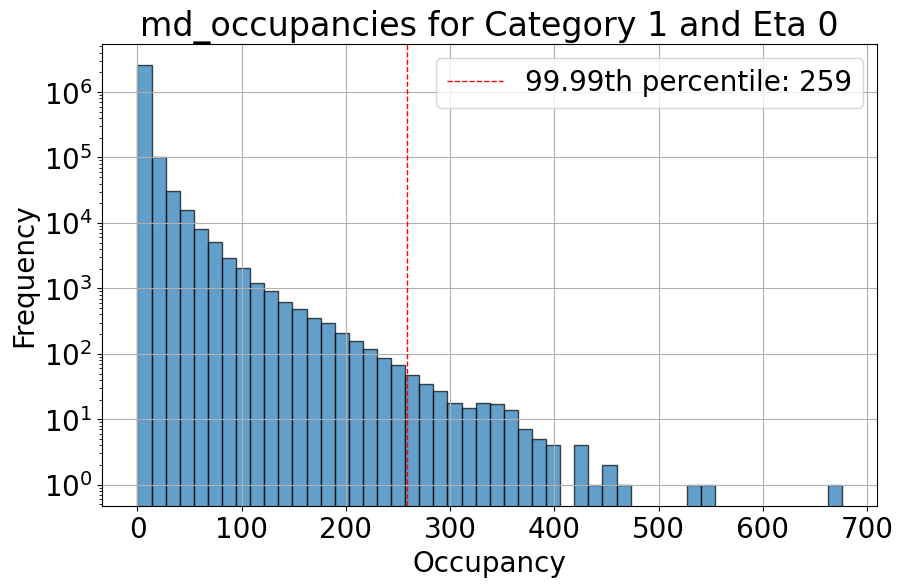

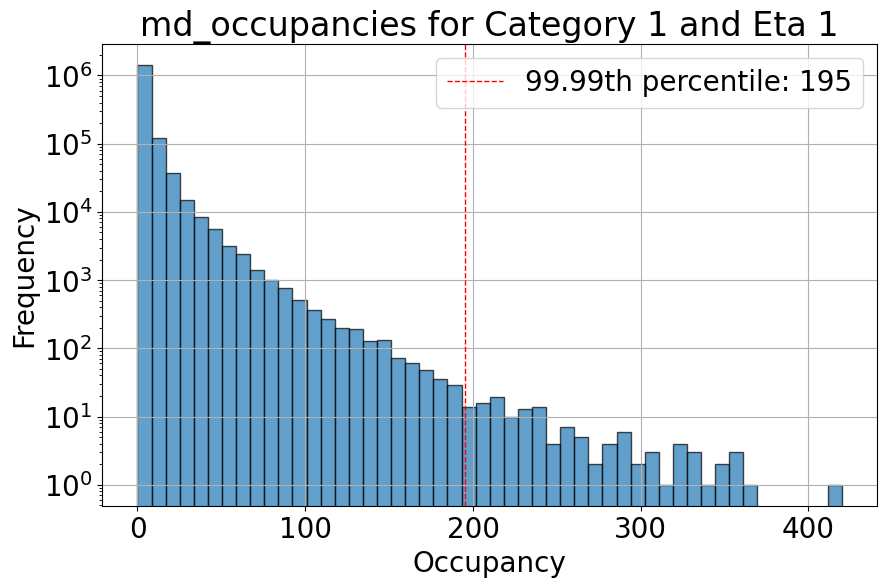

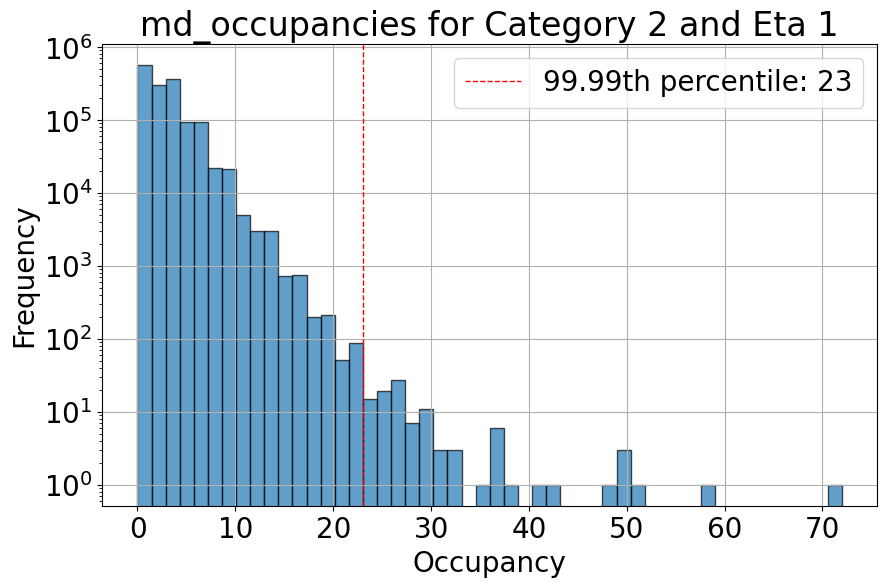

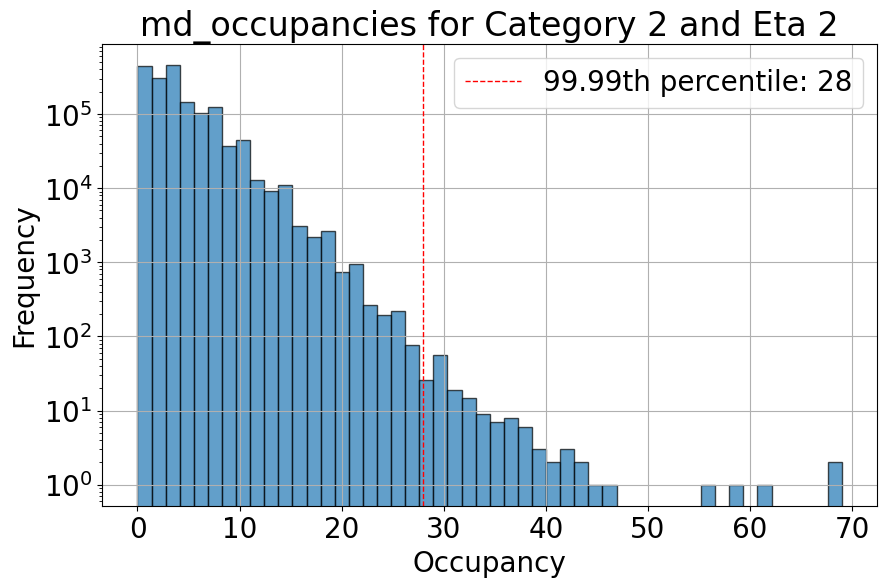

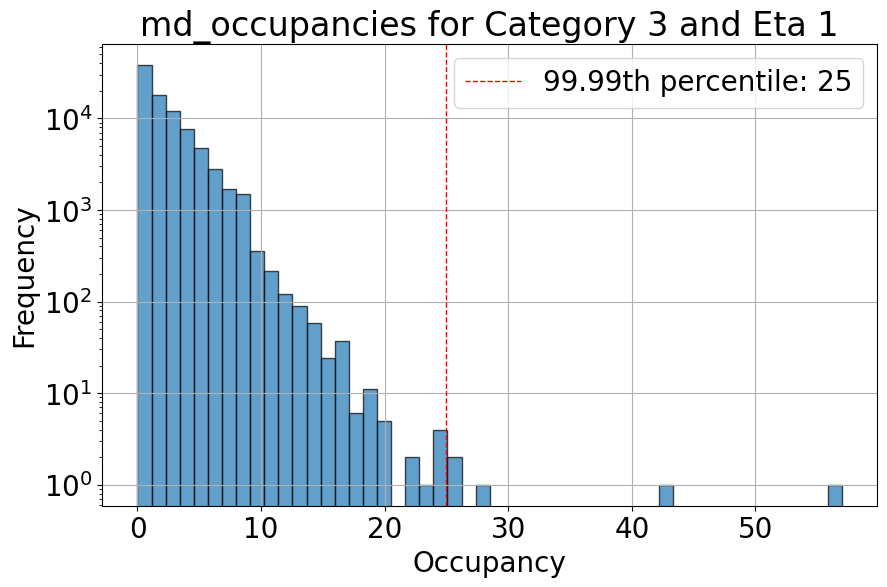

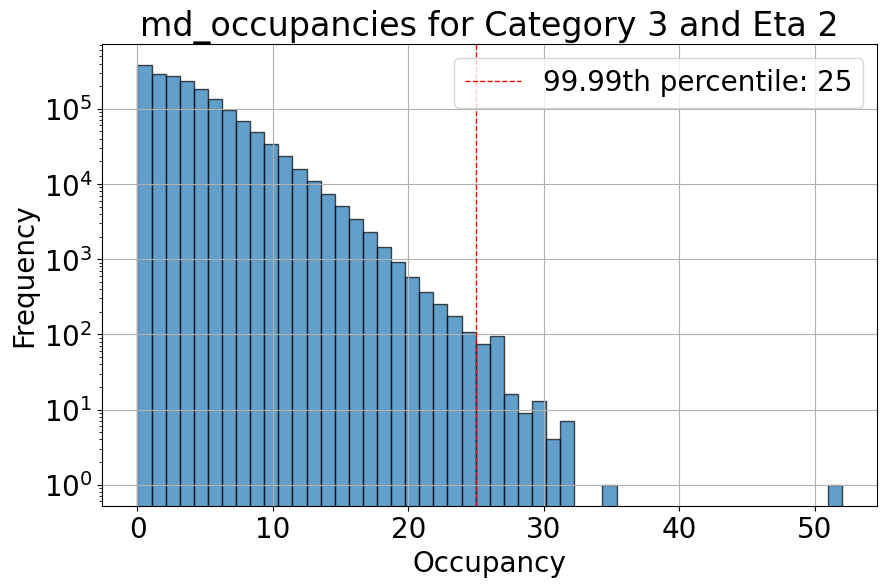

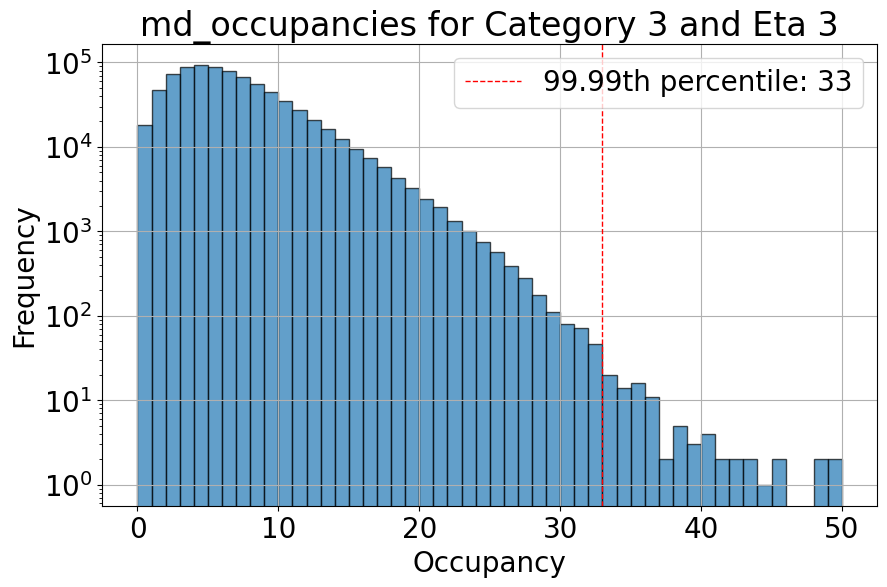

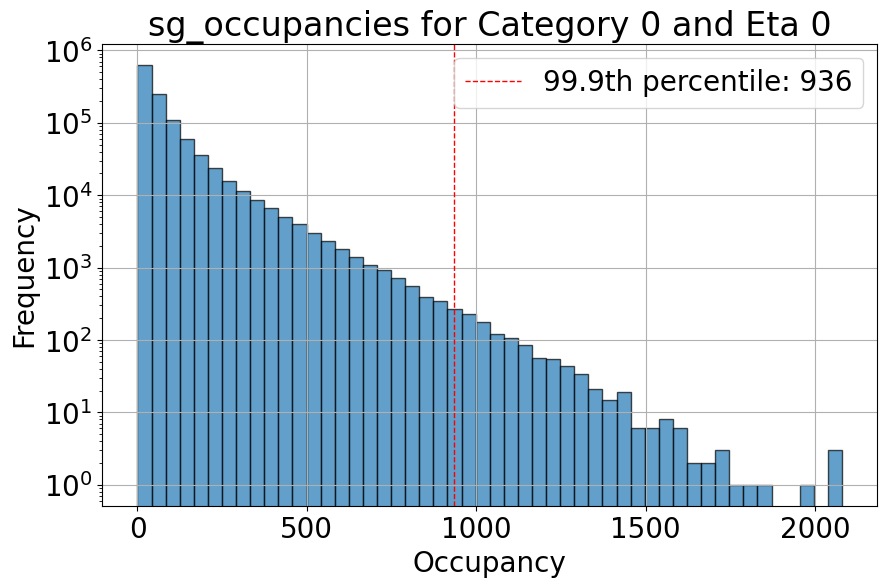

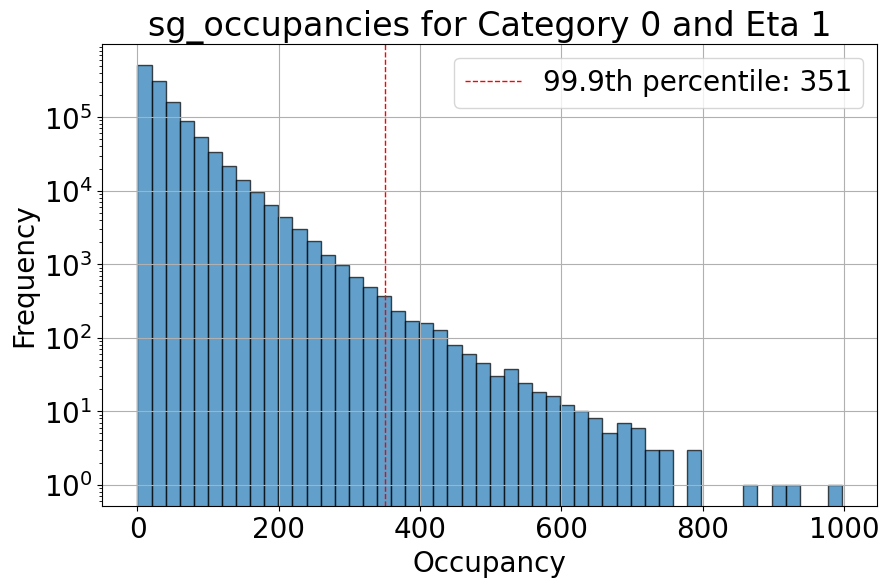

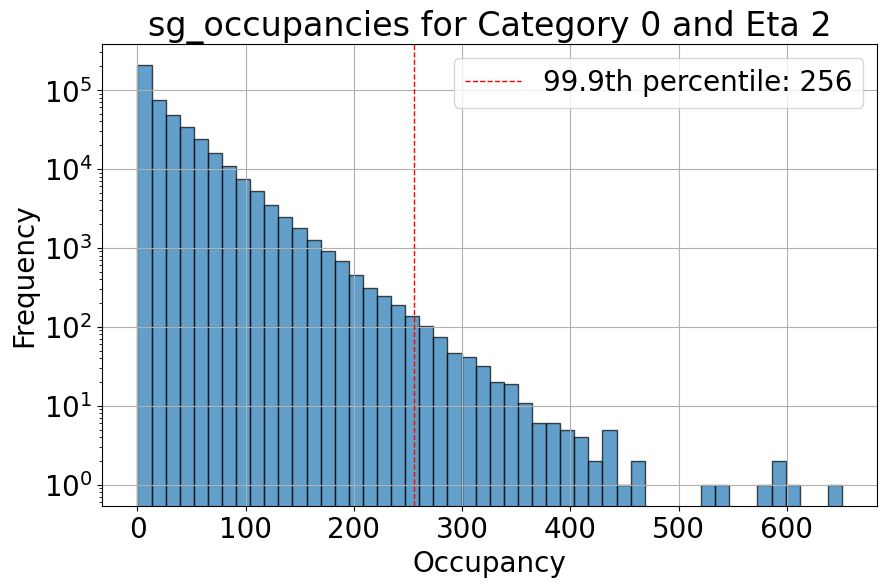

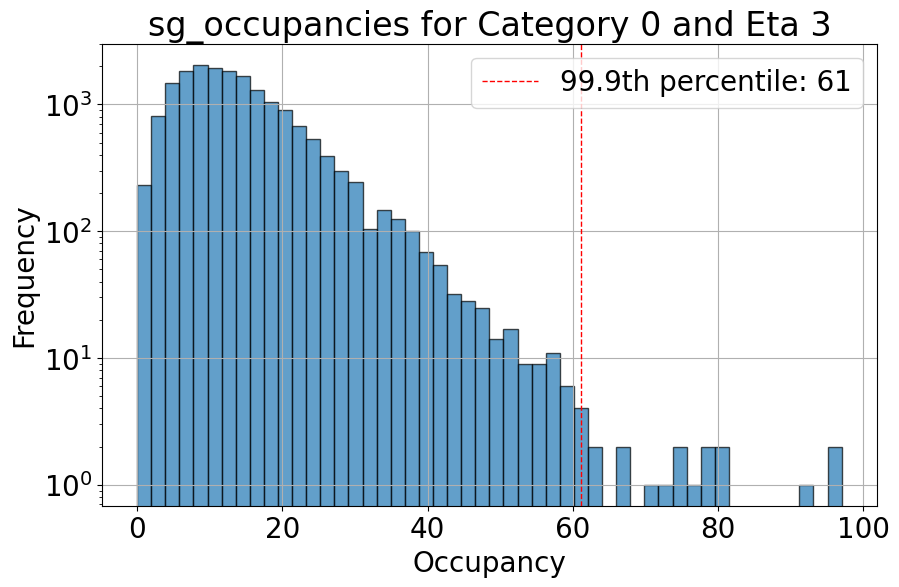

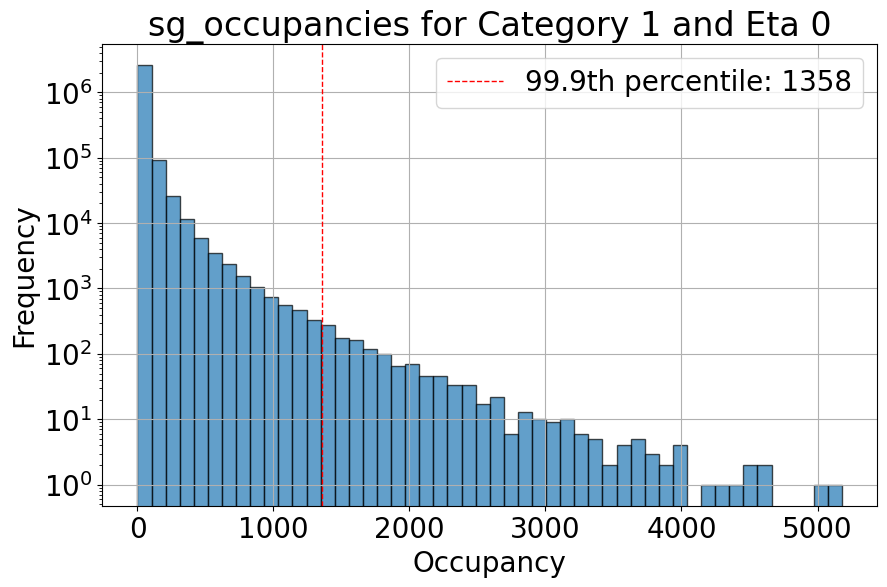

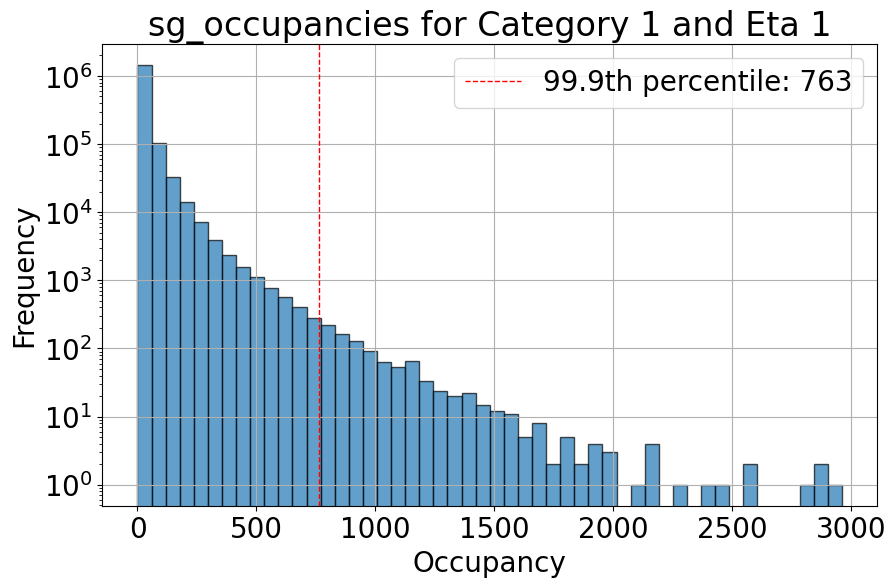

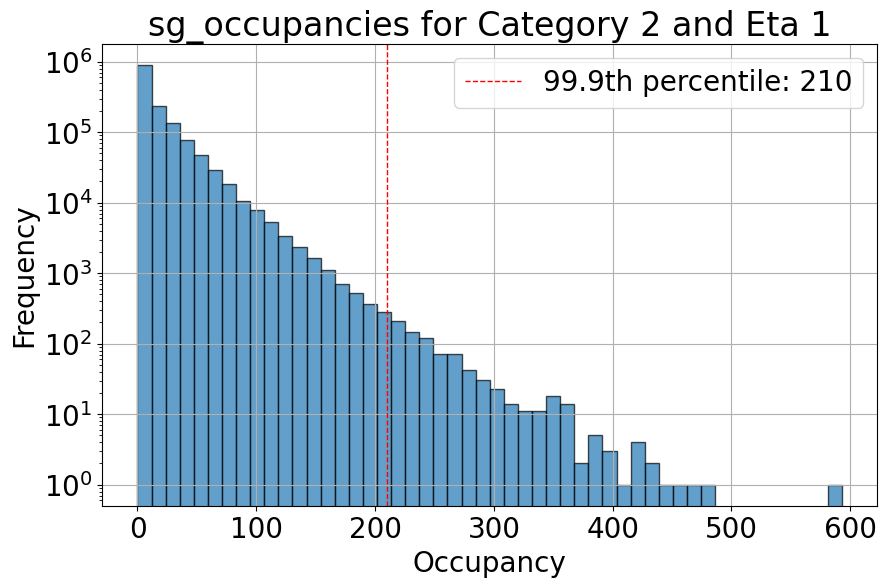

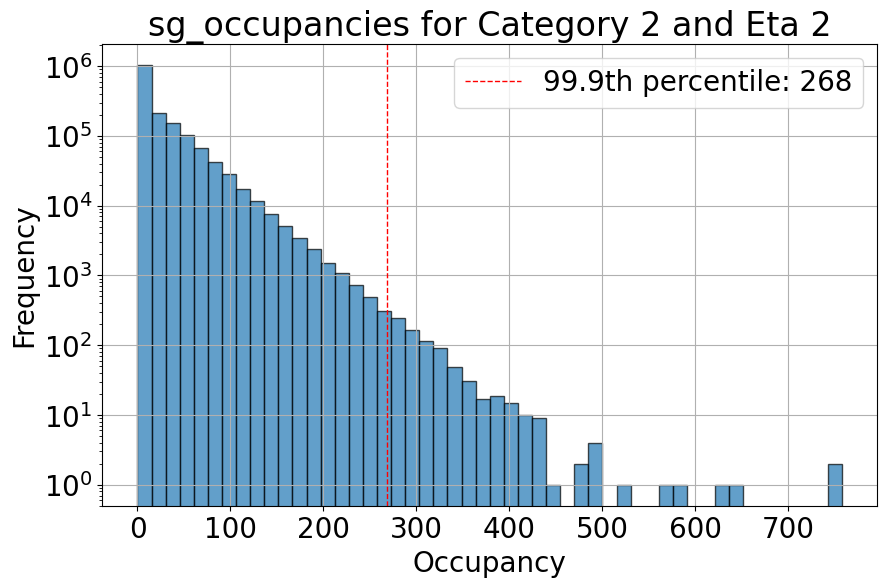

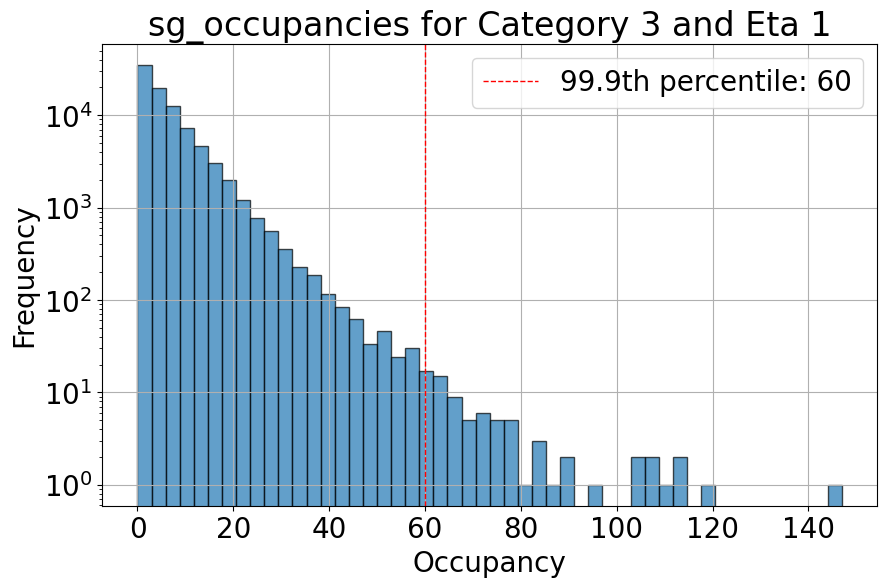

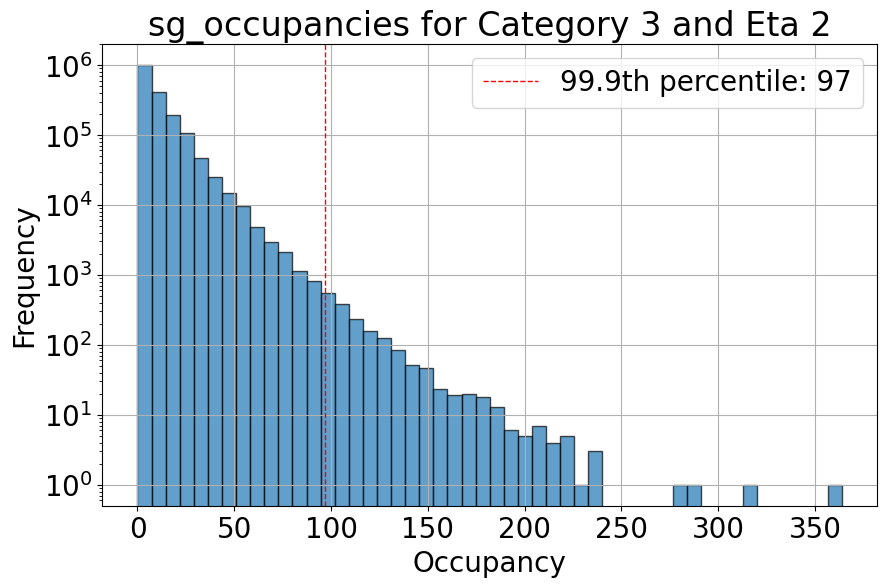

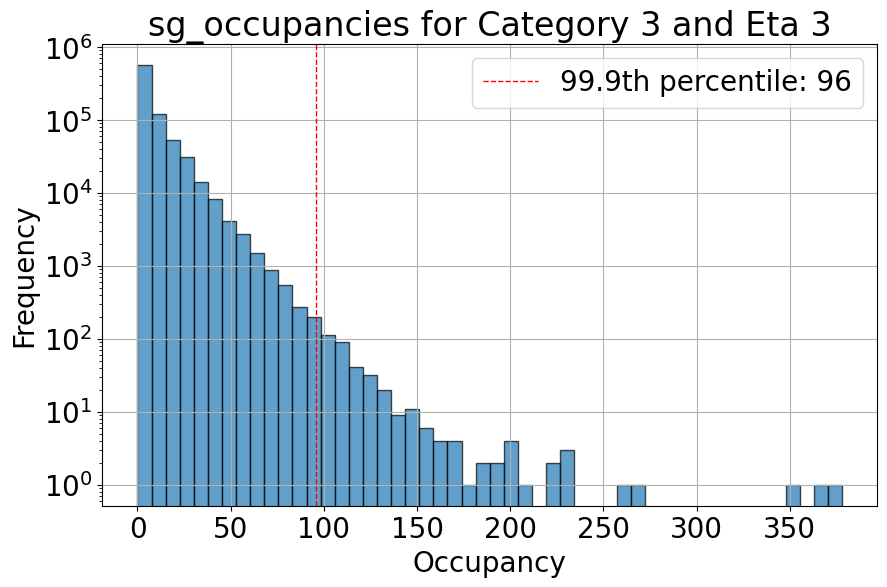

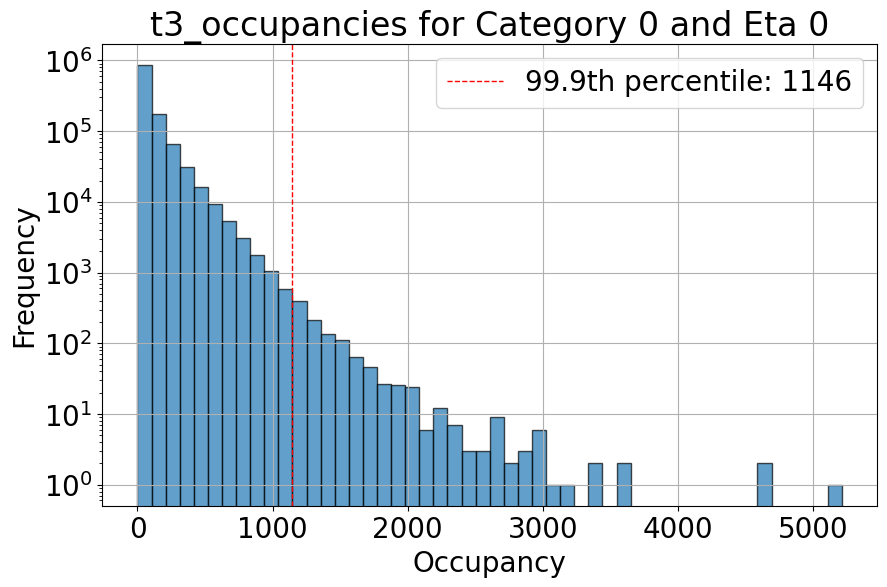

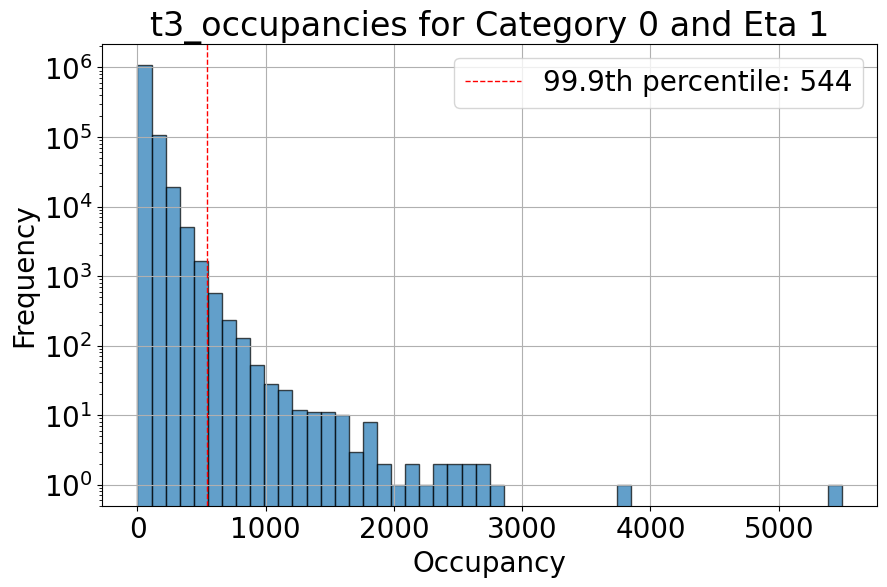

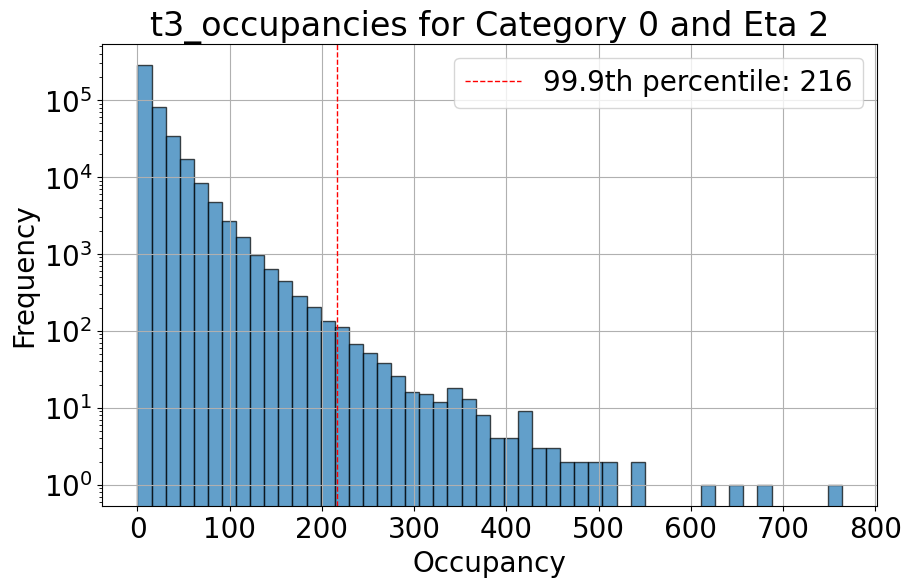

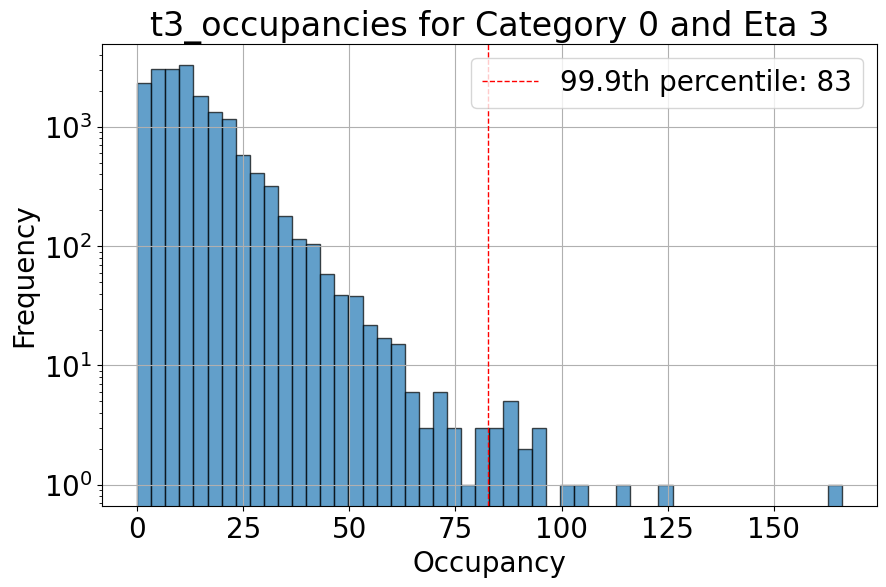

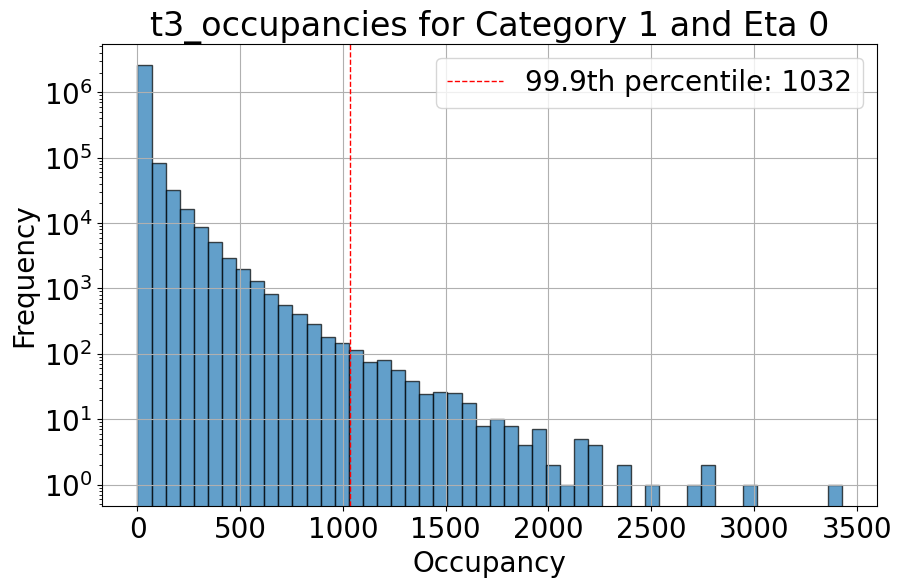

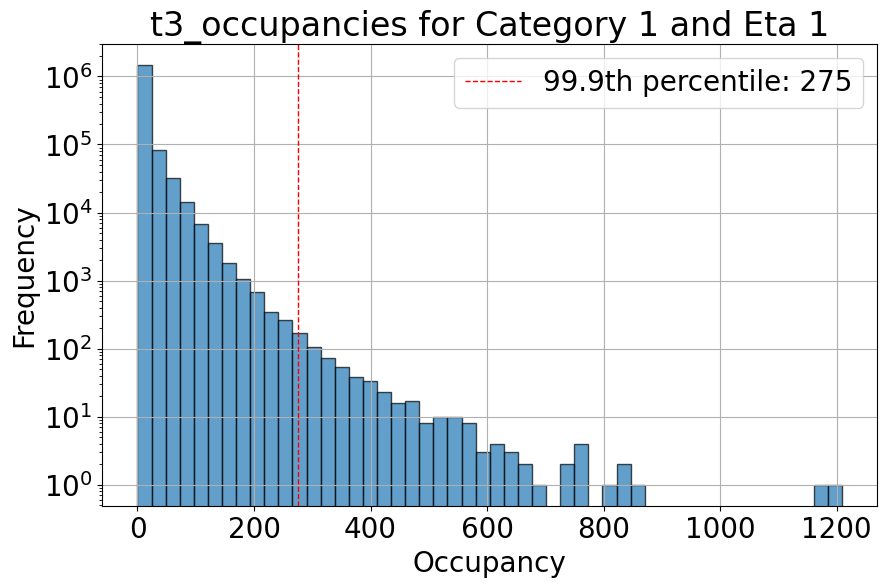

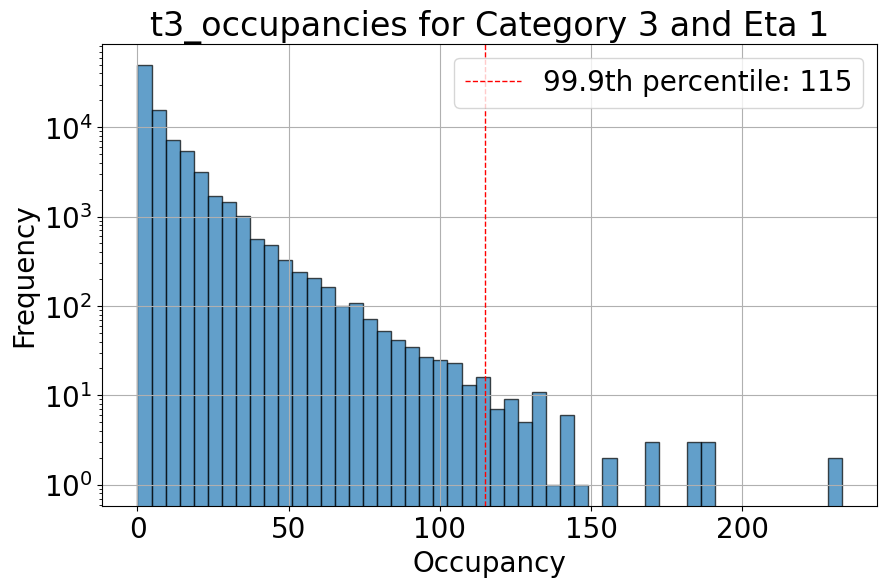

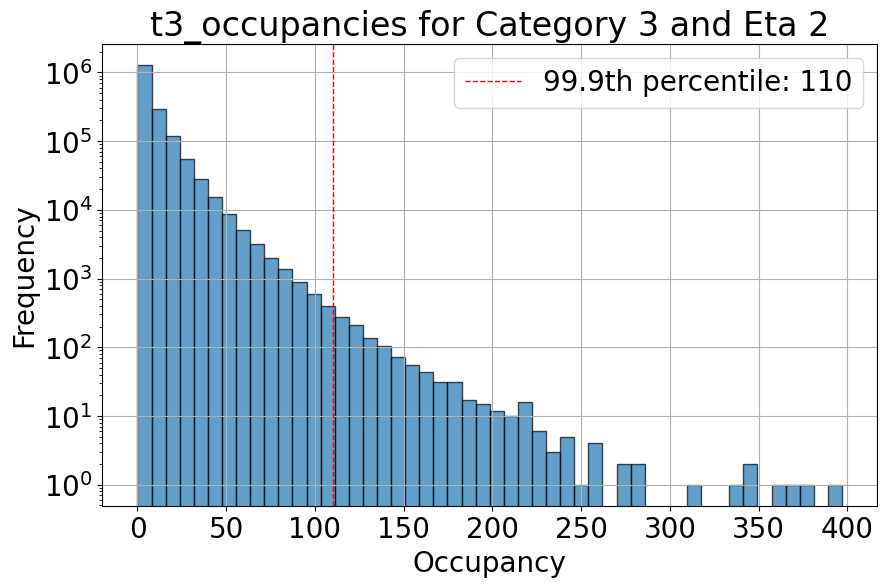

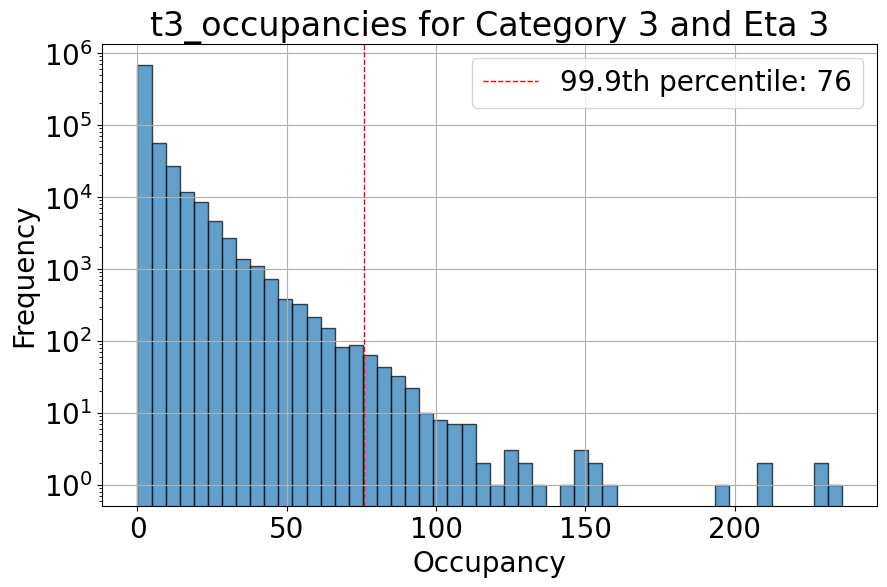

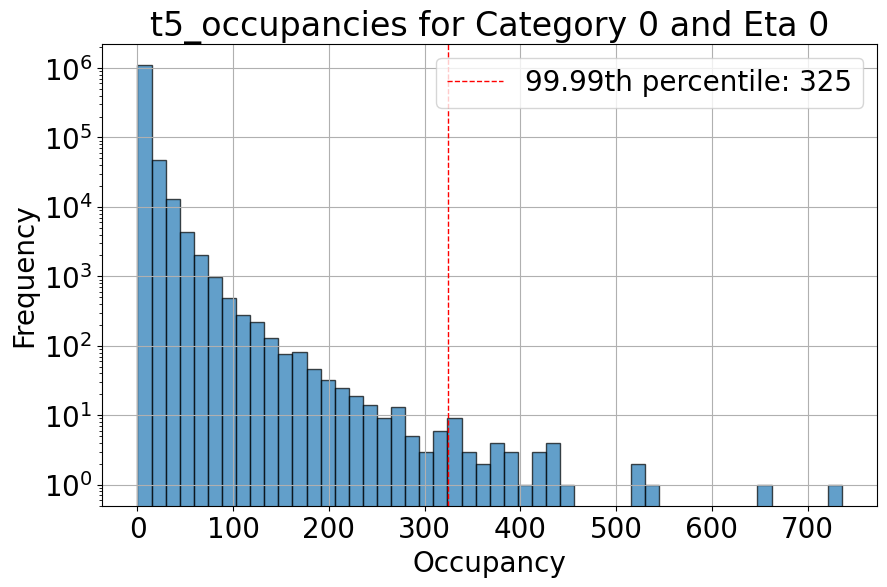

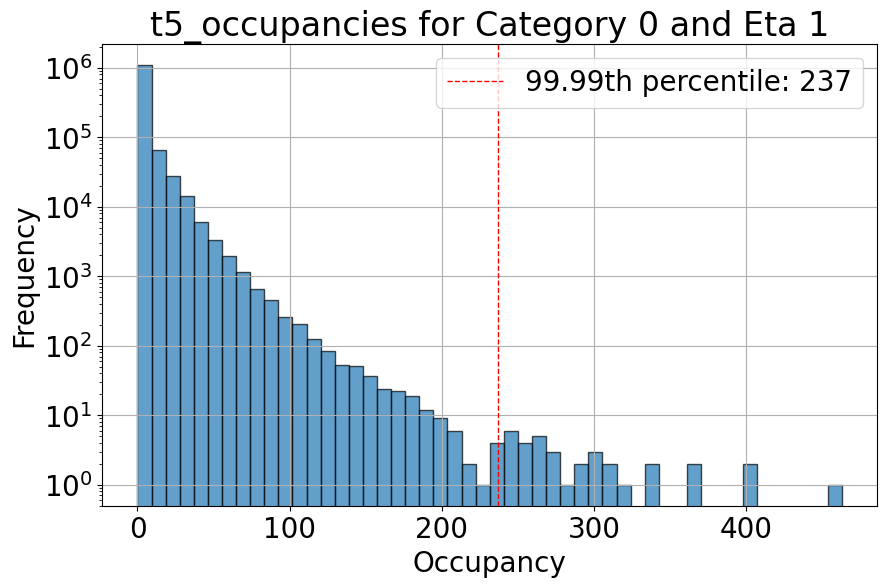

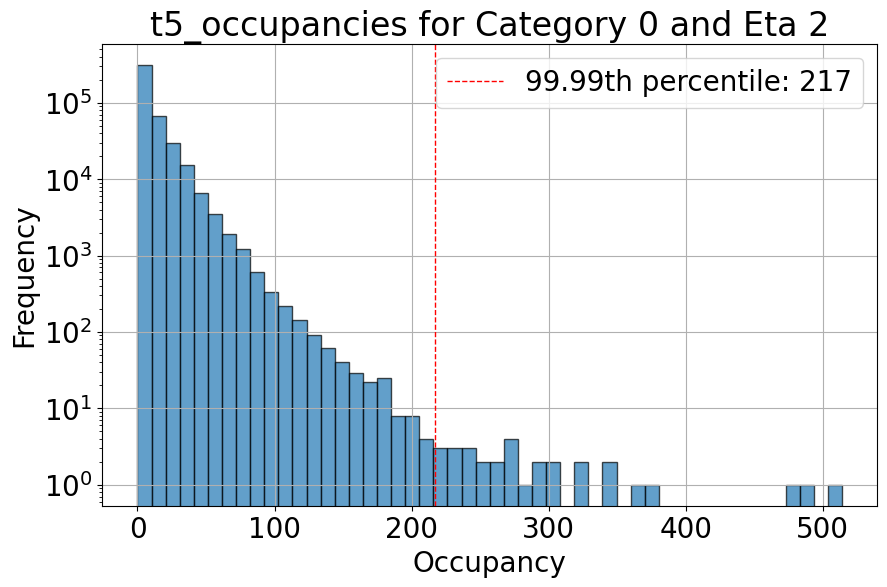

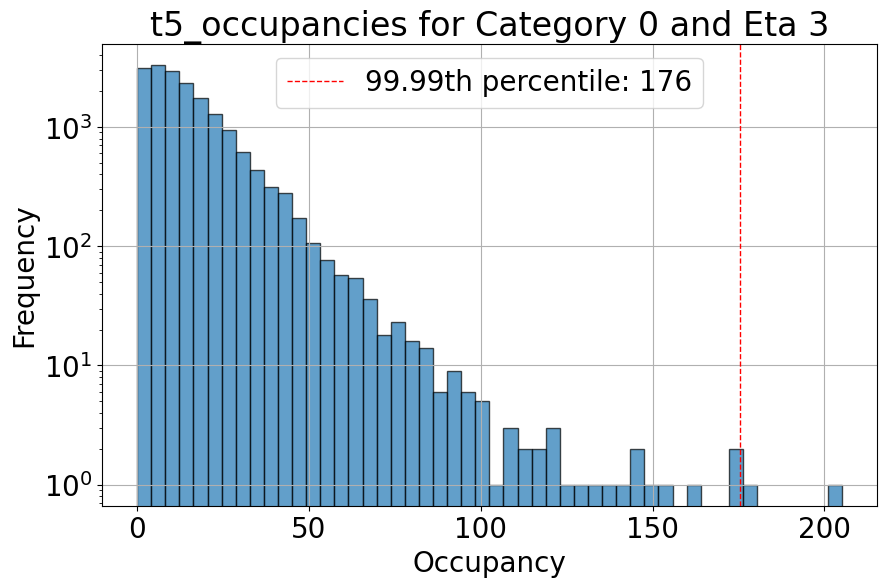

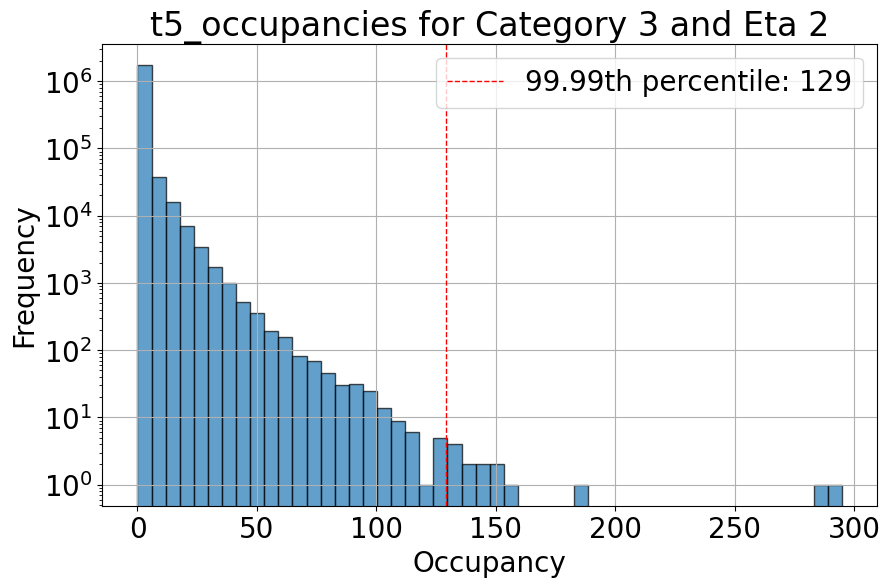

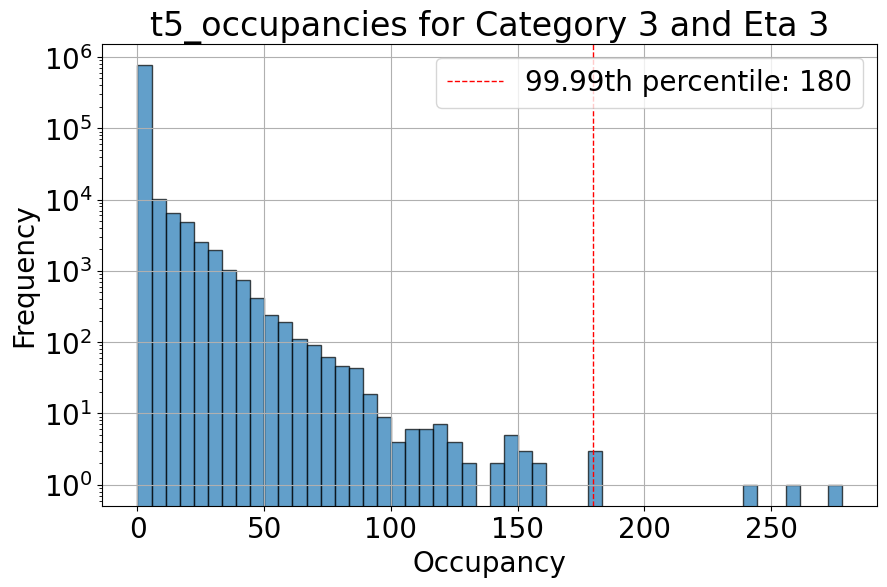

In [5]:
occupancy_variables = ['md_occupancies', 'sg_occupancies', 't3_occupancies', 't5_occupancies']
percents = [99.99, 99.9, 99.9, 99.99]
compute_occupancies(branches, occupancy_variables, occ_percentiles=percents, plot=False)  # To print
compute_occupancies(branches, occupancy_variables, occ_percentiles=percents, plot=True)  # To plot